In [1]:
%pylab inline
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py
%load_ext gvmagic

import tensorflow as tf
sess = tf.InteractiveSession()
def myshow(image, label=None):
  image = image/1.0
  image = image - amin(image)
  image /= amax(image)
  axis('off')
  if label:
    title(label)
  imshow(image)

Populating the interactive namespace from numpy and matplotlib
Installed gvmagic.py. To use it, type:
  %load_ext gvmagic


/usr/local/google/home/keveman/jupyter/local/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


### Image Classification Using TensorFlow

* Task : Classify 32x32 RGB images across 10 categories
  - `airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck`

* Data available at [http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz](http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz)

In [2]:
!stat -c "%-45n %s" data/cifar-10-batches-bin/*

data/cifar-10-batches-bin/data_batch_1.bin    30730000
data/cifar-10-batches-bin/data_batch_2.bin    30730000
data/cifar-10-batches-bin/data_batch_3.bin    30730000
data/cifar-10-batches-bin/data_batch_4.bin    30730000
data/cifar-10-batches-bin/data_batch_5.bin    30730000
data/cifar-10-batches-bin/test_batch.bin      30730000


* Each file is 10000 images, each 32 * 32 RGB, plus one byte for label
  - $(32 \times 32 \times 3 \times 1) \times 10000 = 30730000 \ bytes$

* Read the data

In [3]:
data = []
for i in range(1, 6):
  with open('data/cifar-10-batches-bin/data_batch_%d.bin' % i, 'rb') as batch:
    data.append(batch.read())
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck']

* Decode the raw bytes and create a mini-batch of Tensors

In [4]:
def get_mini_batch(bytes, batch_size):
  img_size = 32 * 32 * 3
  # One 'record' is an image and a label
  record_size = img_size + 1
  images = []
  labels = []
  for i in range(batch_size):
    offset = i * record_size
    # Slice off a record and decode it in to a Tensor of type uint8
    decoded = tf.decode_raw(bytes[offset:offset + record_size], tf.uint8)
    # Slice off the label
    label =  tf.cast(decoded[0:1], tf.int32)
    # Slice off the image and reshape to 3-D
    image = tf.reshape(decoded[1:1+img_size], [3, 32, 32])
    # Reformat from [color, x, y] to [x, y, color]
    image = tf.transpose(image, [1, 2, 0])
    images.append(image)
    labels.append(label)
  return images, labels

* Let's look at the images

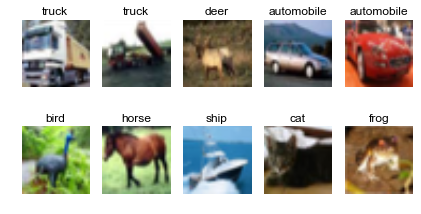

In [5]:
images, labels =  get_mini_batch(data[0], 10)
fig = figure(figsize = (7, 3.5))
for i in range(10):
  image, label = images[i], labels[i]
  subplot(2, 5, i)
  myshow(image.eval(), label_names[label.eval()[0]])

* Let's augment the data set
  - Extract a random 24 x 24 crop
  - Random flip left-to-right
  - Random brightness/contrast
  - Whiten the image (subtract mean, divide by variance)

In [6]:
def distort(image):
  image = tf.random_crop(image, [24, 24, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63./255.)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  # This converts the image to floating point values
  image = tf.image.per_image_whitening(image)
  return image


* Let's look at the images again

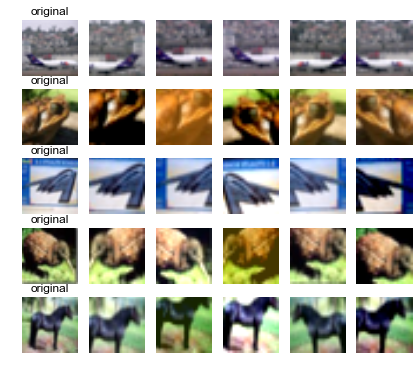

In [7]:
images, _ =  get_mini_batch(data[3], 5)
figsize(7, 6)
for i in range(5):
  subplot(5, 6, i*6+1)
  myshow(images[i].eval(), 'original')
  for j in range(5):
    subplot(5, 6, i*6+j+2)
    myshow(distort(images[i]).eval())


* Let's build a model to classify these images

In [10]:
cifar_model = """
digraph G {
  rankdir=BT;
  a -> b;
  b -> c;
}
"""

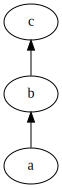

In [11]:
%dotstr cifar_model